# Nonparametric Bayesian Inference

* Example of Dirichlet Process
    - DP using Stick Breaking Process
    - DP using Chinese Restaurant Process
    - Inference using DP
* Example of Dirichlet Process Mixture
    - DPM using VI

## 0. Initialize

In [1]:
#mathematics
using LinearAlgebra
using SpecialFunctions

#dataframe
using DataFrames

#statistics
using Random
using Statistics
using Distributions
using EmpiricalCDFs:EmpiricalCDF,push!,sort!

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

## 1. Example of DP

### 1.1. define functions

In [2]:
#base measure
abstract type AbstractBaseMeasure end
struct BaseMeasure<:AbstractBaseMeasure
    ps::Vector{Float64}
    prior_base::UnivariateDistribution
    emp_dist::DiscreteNonParametric
    function BaseMeasure(prior_base,α,X)
        N = length(X)
        if N==0
            return prior_base
        end
        emp_dist = empirical_dist(X,N)
        return new([α/(N+α),N/(N+α)],prior_base,emp_dist)
    end
end

#empirical distribution
function empirical_dist(X,N)
    data_df = DataFrame(X=X)
    freq_df = combine(groupby(data_df,:X),nrow=>:Freq)
    xs = freq_df.X
    ps = freq_df.Freq/N
    return DiscreteNonParametric(xs,ps)
end

function Base.rand(post_base::BaseMeasure)
    u = rand()
    if u<=post_base.ps[1]
        return rand(post_base.prior_base)
    else
        return rand(post_base.emp_dist)
    end
end

#stick breaking process
function StickBreakingProcess(kmax,prior_base,α,X)
    base = BaseMeasure(prior_base,α,X)
    α += length(X)
    logwghks = zeros(kmax) #weights
    posks = zeros(kmax) #positions
    logwghk = 0.0
    lenk_old = 0.0
    lenk_new = 1/2
    @showprogress for k in 1:kmax
        posk = rand(base)
        posks[k] = posk
        lenk_old = lenk_new
        lenk_new = rand(Beta(1,α))
        logwghk += log(lenk_new)-log(lenk_old)+log(1-lenk_old)
        logwghks[k] = logwghk
    end
    emp_df = combine(groupby(DataFrame(pos=posks,prob=exp.(logwghks)),:pos),:prob=>sum)
    return DiscreteNonParametric(emp_df.pos,emp_df.prob_sum)
end 
StickBreakingProcess(kmax,base,α) = StickBreakingProcess(kmax,base,α,[])

#sample X
function sampleF(ecdf,F₀,α,n)
    u = rand()
    if u<=(n-1)/(n+α-1)
        samp = rand(ecdf)
    else
        samp = rand(F₀)
    end
    return samp
end

#Chinese Restaurant Process
function ChineseRestaurantProcess(N,F₀,α)
    ecdf = EmpiricalCDF()
    samps = zeros(N)
    samps[1] = rand(F₀)
    for n in 2:N
        samp = sampleF(ecdf,F₀,α,n)
        samps[n] = samp
        push!(ecdf,samp)
        sort!(ecdf)
    end
    return samps,ecdf
end

#random number from π₁F₁+π₂F₂
function Base.rand(F₁,F₂,π₁,π₂)
    u = rand()
    if u<=π₁
        return rand(F₁)
    else
        return rand(F₂)
    end
end

### 1.2. sampling from DP: Stick Breaking Process

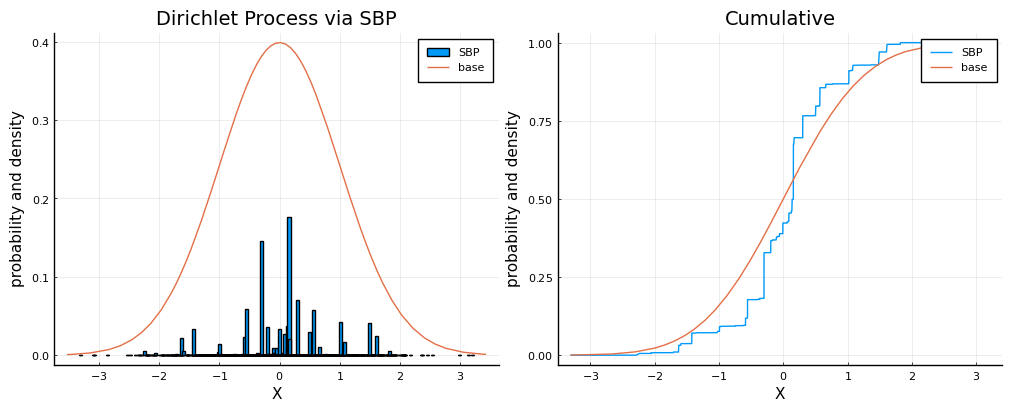

  5.858448 seconds (14.66 M allocations: 893.706 MiB, 4.51% gc time, 99.94% compilation time)


In [3]:
#base distiribution and intensity parameter
α = 10
prior_base = Normal(0,1)

#sample via SBP
Random.seed!(42)
kmax = Int(1e3)
@time Fsamp = StickBreakingProcess(kmax,prior_base,α)

#visualize
p1 = plot(Fsamp.support,Fsamp.p,st=:bar,xlabel="X",ylabel="probability and density",
    label="SBP",bar_width=0.05,title="Dirichlet Process via SBP")
plot!(x->pdf(prior_base,x),label="base")
p2 = plot(Fsamp.support,cumsum(Fsamp.p),title="Cumulative",xlabel="X",ylabel="probability and density",
    label="SBP")
plot!(x->cdf(prior_base,x),label="base")
fig1 = plot(p1,p2,size=(1000,400))
savefig(fig1,"figs-NPB/fig1.png")

### 1.3. sampling X: Chinese Restaurant Process

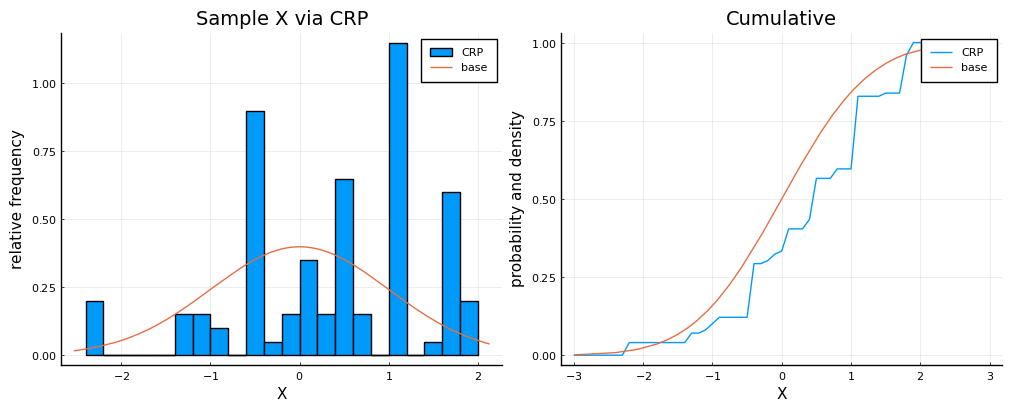

  0.047633 seconds (42.81 k allocations: 2.596 MiB, 99.74% compilation time)


In [4]:
#sample from CRP
Random.seed!(42)
N = 100
α = 10
prior_base = Normal(0,1)
@time xsamps,ecdf = ChineseRestaurantProcess(N,prior_base,α)

#visualize
p1 = histogram(xsamps,normed=true,bins=20,xlabel="X",ylabel="relative frequency",title="Sample X via CRP",
    label="CRP")
plot!(x->pdf(prior_base,x),label="base")
p2 = plot(-3:0.1:3,x->ecdf(x),title="Cumulative",xlabel="X",ylabel="probability and density",label="CRP")
plot!(x->cdf(prior_base,x),label="base")
fig2 = plot(p1,p2,size=(1000,400))
savefig(fig2,"figs-NPB/fig2.png")

### 1.4. Inference using DP

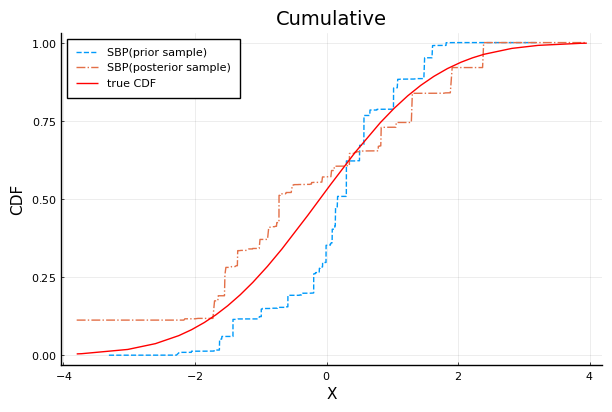

In [5]:
#set the random seed
Random.seed!(42)

#create data
N = 10
true_dist = Normal(-0.1,1.4)
X = rand(true_dist,N)

#model and algorithm parameters
α = 10
prior_base = Normal(0,1)

#prior sampling
kmax = Int(1e3)
prior_F_samp = StickBreakingProcess(kmax,prior_base,α)
fig3 = plot(prior_F_samp.support,cumsum(prior_F_samp.p),title="Cumulative Estimation",
    xlabel="X",ylabel="CDF",label="SBP(prior sample)",legend=:topleft,ls=:dash)

#posterior sampling
post_F_samp = StickBreakingProcess(kmax,prior_base,α,X)
plot!(post_F_samp.support,cumsum(post_F_samp.p),title="Cumulative",label="SBP(posterior sample)",ls=:dashdot)
plot!(x->cdf(true_dist,x),label="true CDF",color=:red)
savefig(fig3,"figs-NPB/fig3.png")

## 2. Example of DPM

### 2.1. functions - Variational Inference

In [6]:
#variational parameters and distirbutions
abstract type AbstractVariationalParameters end
abstract type AbstractVariationalDistributions end
mutable struct VariationalParameters<:AbstractVariationalParameters
    αks::Vector{Float64}
    βks::Vector{Float64}
    σksqs::Vector{Float64}
    μks::Matrix{Float64}
    πns::Matrix{Float64}
    function VariationalParameters(α,σ₀sq,d,K,N)
        αks = α*ones(K)
        βks = ones(K)
        σksqs = σ₀sq*ones(K)
        μks = zeros(d,K)
        πns = ones(K,N)/K
        return new(αks,βks,σksqs,μks,πns)
    end
end
mutable struct VariationalDistributions<:AbstractVariationalDistributions
    vk_dists::Vector{Distribution}
    θk_dists::Vector{Distribution}
    zn_dists::Vector{Distribution}
    function VariationalDistributions(params::VariationalParameters)
        @unpack αks,βks,σksqs,μks,πns = params
        vk_dist = []; θk_dist = []; πn_dist = [];
        for k in 1:K-1
            push!(vk_dist,Beta(αks[k],βks[k]))
        end
        for k in 1:K
            push!(θk_dist,MvNormal(μks[:,k],σksqs[k]))
        end
        for n in 1:N
            push!(πn_dist,Categorical(πns[:,n]))
        end
        return new(vk_dist,θk_dist,πn_dist)
    end
end

#data and model parameters
abstract type AbstractData end
abstract type AbstractModelParameters end
struct Data<:AbstractData
    X::Matrix{Float64}
    N::Int64
end
struct ModelParameters<:AbstractModelParameters
    α::Float64
    σsq::Float64
    σ₀sq::Float64
    d::Int64
    K::Int64
end

#update v's distriibution
function update_vks!(var_params,α,K)
    for k in 1:K-1
        var_params.αks[k] = α + sum(var_params.πns[k,:])
        var_params.βks[k] = 1 + sum(var_params.πns[k+1:end,:])
    end
end

#update θ's distribution
function update_θks!(var_params,X,σsq,σ₀sq,K)
    for k in 1:K
        var_params.σksqs[k] = 1/(1/σ₀sq+sum(var_params.πns[k,:])/σsq)
        var_params.μks[:,k] = var_params.σksqs[k]*(X*var_params.πns[k,:])/σsq
    end
end

#logτk(log unnormalized probability of zk)
logτk(var_params,k,n,X,σsq,d) = (
    -(norm(var_params.μks[:,k])^2+d*var_params.σksqs[k]-2*dot(var_params.μks[:,k],X[:,n]))/2/σsq 
    + digamma(var_params.αks[k])-digamma(var_params.αks[k]+var_params.βks[k])
    +sum(digamma.(var_params.βks[1:k-1])-digamma.(var_params.αks[1:k-1]+var_params.βks[1:k-1]))
)

#update z's distribution
function update_zns!(var_params)
    for n in 1:N
        for k in 1:K
            var_params.πns[k,n] = exp(logτk(var_params,k,n,X,σsq,d))
        end
        var_params.πns[:,n] = var_params.πns[:,n]/sum(var_params.πns[:,n])
    end
end

#mean field variational inference
function VariationalInference(data,n_train,model_params)
    #initialize
    @unpack X,N = data
    @unpack α,σsq,σ₀sq,d,K = model_params
    var_params = VariationalParameters(α,σ₀sq,d,K,N)
    
    #update variational parameters
    @showprogress for s in 1:n_train
        update_vks!(var_params,α,K)
        update_θks!(var_params,X,σsq,σ₀sq,K)
        update_zns!(var_params)
    end
    
    #variational distirbutions
    return VariationalDistributions(var_params)
end

VariationalInference (generic function with 1 method)

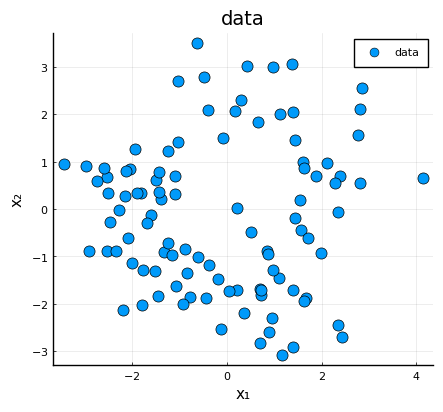

In [7]:
#set the random seed
Random.seed!(40)

#Guassian mixture 
θ = 2*π/5
μ_func(i, θ) = 2*[cos(π/10+i*θ), sin(π/10+i*θ)]
Σ = I(2)/2
μ₀ = μ_func(0, θ)
μ₁ = μ_func(1, θ)
μ₂ = μ_func(2, θ)
μ₃ = μ_func(3, θ)
μ₄ = μ_func(4, θ)
true_dist = MixtureModel(
    [MvNormal(μ₀,Σ), MvNormal(μ₁,Σ), MvNormal(μ₂,Σ), MvNormal(μ₃,Σ), MvNormal(μ₄,Σ)]
)

#data
N = 100
X = rand(true_dist, N)
data = Data(X,N)

#visualize
fig4 = plot(X[1,:],X[2,:],st=:scatter,label="data",xlabel="x₁",ylabel="x₂",title="data",aspect_ratio=1,
markerstrokewidth=0.5,markersize=8)
savefig(fig4,"figs-NPB/fig4.png")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


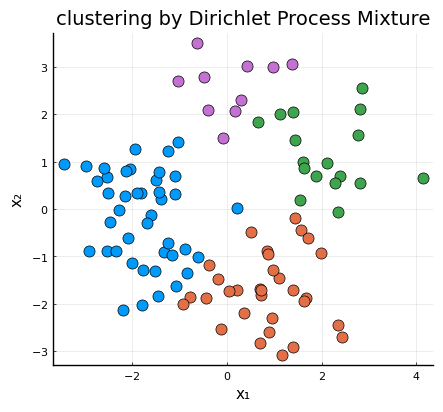

  6.058042 seconds (45.63 M allocations: 5.649 GiB, 14.13% gc time, 20.84% compilation time)


In [8]:
#initialize model parameters
α = 0.8
σsq = 1
σ₀sq = 4
d = 2
K = 30
model_params = ModelParameters(α,σsq,σ₀sq,d,K)

#mean field variational inference for Dirichlet Process Mixture Model
n_train = 1000
@time var_dists = VariationalInference(data,n_train,model_params)

#visualize
zns = [argmax(var_dists.zn_dists[n].p) for n in 1:N]
fig5 = plot(X[1,:],X[2,:],group=zns,st=:scatter,markerstrokewidth=0.5,markersize=8,label=false,aspect_ratio=1,
title="clustering by Dirichlet Process Mixture",xlabel="x₁",ylabel="x₂")
savefig(fig5,"figs-NPB/fig5.png")